In [1]:
import torch
import numpy as np, cv2, pandas as pd, glob, time, os
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
import time
import spacy
from torchsummary import summary
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
import pickle

In [3]:
data_location = "./data/flickr_8k/"
BATCH_SIZE = 64

spacy_eng = spacy.load("en_core_web_sm")

In [4]:
caption_df = pd.read_csv(data_location+"captions.txt")
caption_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
flk_30k_cap = pd.read_csv("./data/flickr_30k/flickr30k_images/results.csv", sep='|')
flk_30k_cap.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [6]:
def checkType(x):
    if type(x) == str:
        return True
    else:
        return False

In [7]:
flk_30k_cap['checknum'] = flk_30k_cap[' comment'].apply(lambda x: checkType(x))

In [ ]:
flk_30k_cap.shape

In [8]:
flk_30k_cap = flk_30k_cap.loc[flk_30k_cap.checknum]

In [ ]:
flk_30k_cap.info()

In [ ]:
caption_df.image.unique().shape[0]*0.2

In [ ]:
caption_df.image.unique()[:1618].shape

In [9]:
train_capdf = caption_df.loc[caption_df.image.isin(caption_df.image.unique()[1000:])].reset_index()
test_capdf = caption_df.loc[caption_df.image.isin(caption_df.image.unique()[:1000])].reset_index()
print(train_capdf.shape, test_capdf.shape)

(35455, 3) (5000, 3)


In [ ]:
#### Declare model and transformation

In [10]:
model_weight = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1
model_ = models.efficientnet_v2_m(weights=model_weight.DEFAULT)
transformation_effv2 = model_weight.transforms()

In [ ]:
img = Image.open("./data/flickr_8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")

In [11]:
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [11]:
class Vocabulary:
    def __init__(self, freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #String to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
                    
    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

In [13]:
vcb = Vocabulary(freq_threshold=5)

vcb.build_vocab(flk_30k_cap[' comment'].tolist()+caption_df.caption.tolist())
print(vcb.numericalize("This is a good place to find a city here!!"))

[289, 17, 7, 1397, 490, 48, 1924, 7, 146, 1613, 1492, 1492]


In [14]:


class FlickrCaptionDataset(Dataset):
    def __init__(self, df, root_dir, vcb, transform=None, tfms=None, freq_threshold=5):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = vcb
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)
    
    

In [15]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [16]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [17]:
#writing the dataloader
#setting the constants
#BATCH_SIZE = 4

#token to represent the padding


train_dataset =  FlickrCaptionDataset(
    df = train_capdf,
    root_dir = data_location+"/Images",
    vcb=vcb,
    transform = transformation_effv2
)

train_pad_idx = vcb.stoi["<PAD>"]

train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=train_pad_idx,batch_first=True)
)

In [18]:
#writing the dataloader
#setting the constants
#BATCH_SIZE = 4

#token to represent the padding


test_dataset =  FlickrCaptionDataset(
    df = test_capdf,
    root_dir = data_location+"/Images",
    vcb=vcb,
    transform = transformation_effv2
)

test_pad_idx = vcb.stoi["<PAD>"]

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=test_pad_idx,batch_first=True)
)

## Select model

In [19]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [20]:
class EncoderCNN(nn.Module):
    def __init__(self, model):
        super(EncoderCNN, self).__init__()
        for param in model.parameters():
            param.requires_grad_(False)
        
        modules = list(model.children())[:-2]
        self.ml = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.ml(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [ ]:
summary(EncoderCNN(model_), models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()(img).unsqueeze(0));

In [21]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        h_ = h
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length-1):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        alpha,context = self.attention(features, h)
        lstm_input = torch.cat((embeds[:, s], context), dim=1)
        h, c = self.lstm_cell(lstm_input, (h, c))
                    
        output = self.fcn(self.drop(h+h_))
            
        preds[:,s] = output
        alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [22]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim, vision_model,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(vision_model)
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(train_dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [22]:
dataiter = iter(train_data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

image,caption = images[0].to(device),captions[0].to(device)

In [ ]:
image.unsqueeze(0).shape

In [25]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [23]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(train_dataset.vocab),
    attention_dim=512,
    encoder_dim=1280,
    decoder_dim=512,
    vision_model=model_
).to(device)

In [ ]:
outputs,attentions = model(image.unsqueeze(0),caption.unsqueeze(0))

In [24]:
summary(model, (image.unsqueeze(0),caption.unsqueeze(0)));

Layer (type:depth-idx)                             Output Shape              Param #
├─EncoderCNN: 1-1                                  [-1, 225, 1280]           --
|    └─Sequential: 2-1                             [-1, 1280, 15, 15]        --
|    |    └─Sequential: 3-1                        [-1, 1280, 15, 15]        (52,858,356)
├─DecoderRNN: 1-2                                  [-1, 31, 8171]            --
|    └─Embedding: 2-2                              [-1, 32, 300]             2,451,300
|    └─Linear: 2-3                                 [-1, 512]                 655,872
|    └─Linear: 2-4                                 [-1, 512]                 655,872
|    └─Attention: 2-5                              [-1, 225]                 --
|    |    └─Linear: 3-2                            [-1, 225, 512]            655,872
|    |    └─Linear: 3-3                            [-1, 512]                 262,656
|    |    └─Linear: 3-4                            [-1, 225, 1]              5

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [27]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(train_dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state_eff.pth')

In [28]:
def validate_batch(img, cap, model, criteria):
    model.eval()

    with torch.no_grad():
        img,cap = img.to(device),cap.to(device)
        outputs,attentions = model(img, cap)
        targets = cap[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
    
    return loss

In [29]:
num_epochs = 150
print_every = 100

patience = 3
best_loss = 10000
no_improve = 0

train_losses = []
val_losses = []

In [ ]:

start = time.time()
for epoch in range(1,num_epochs+1):
    epoch_train_loss, epoch_test_loss = 0, 0
    for idx, (image, captions) in enumerate(iter(train_data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        epoch_train_loss += loss.item()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(train_data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=train_dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
            
    for idx, (image, captions) in enumerate(iter(test_data_loader)):
        v_loss = validate_batch(image, captions, model, criterion)
        epoch_test_loss += v_loss
        
            
    elapsed = time.time()-start
     
    epoch_train_loss /= len(train_data_loader)
    epoch_test_loss /= len(test_data_loader)
    
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_test_loss)
    
    if no_improve < patience:
        if best_loss > epoch_test_loss:
            best_loss = epoch_test_loss
            #save the latest model
            save_model(model,epoch)
            no_improve = 0
        else:
            no_improve+=1
    else:
        break
        
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch, num_epochs, time.time()-start,(num_epochs-epoch)*(elapsed/(epoch+1))))
    
    info = f"""Epoch: {epoch+1:03d} \tTrain Loss: {epoch_train_loss:.3f} \tVal Loss: {epoch_test_loss:.3f} \tBest val Loss: {best_loss:.4f}"""
    print(info)
    
        
    
    
    

In [31]:
torch.save(model, "captioning_model.pt")

In [32]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(15,15)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [33]:
with open('captioning_vocab.pkl', 'wb') as f:  # open a text file
    pickle.dump(train_dataset.vocab, f) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 480, 480])


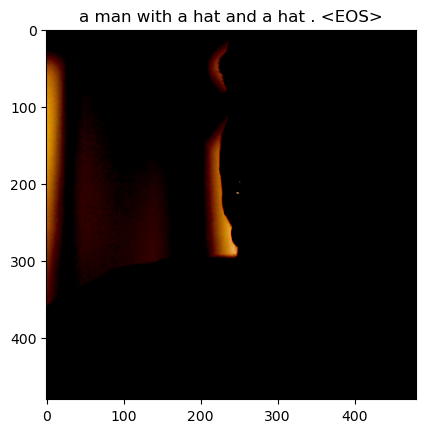

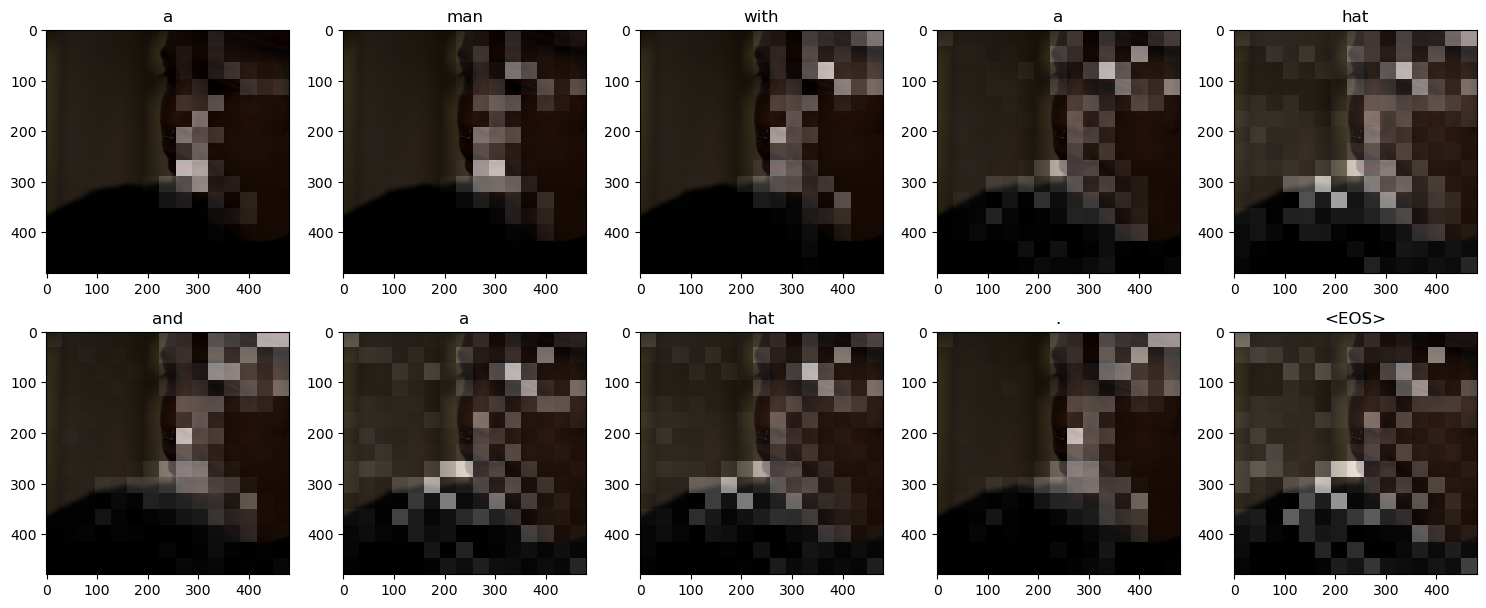

In [34]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
print(img.shape)
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


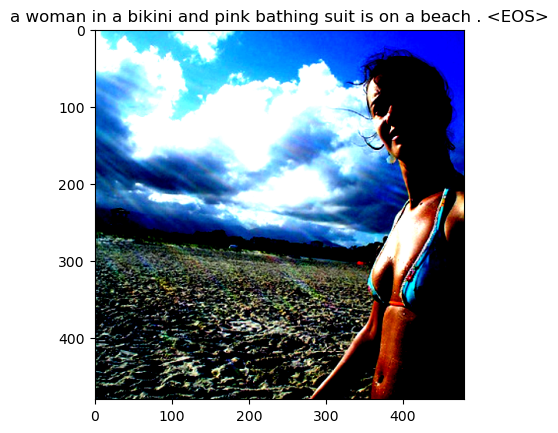

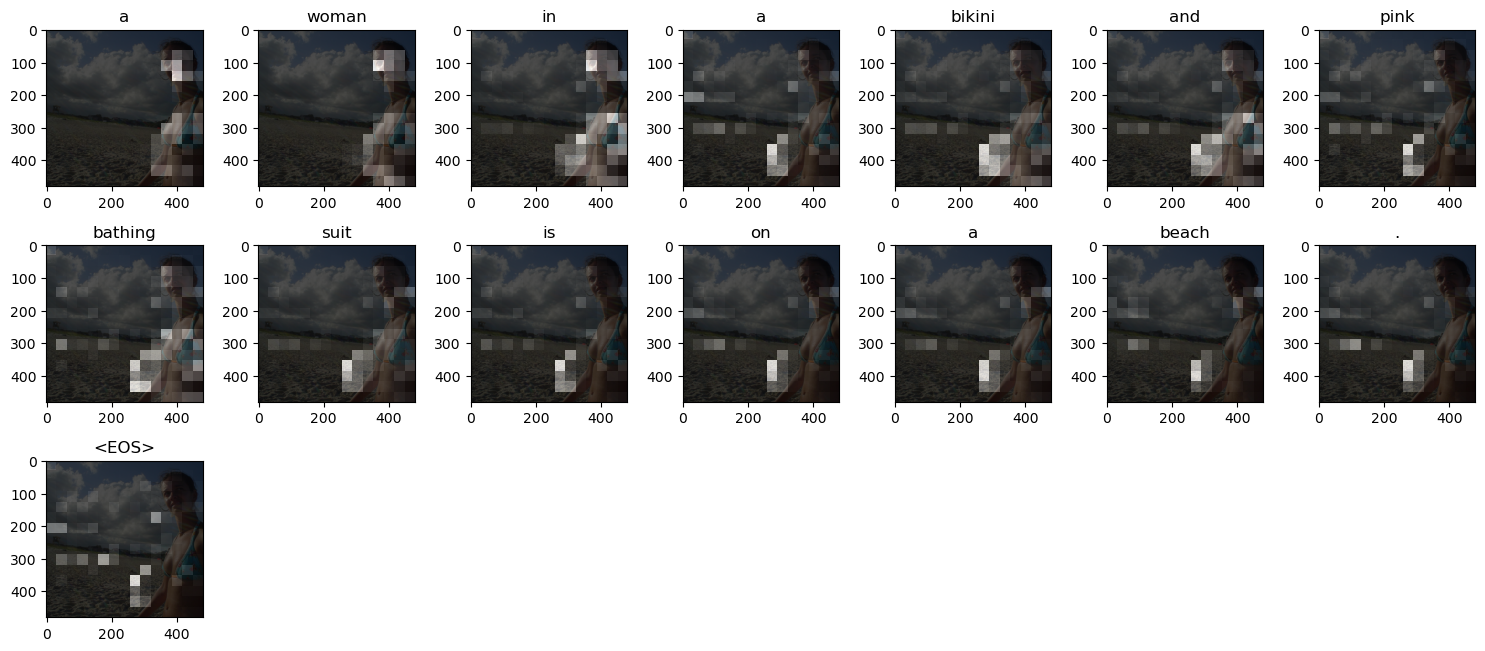

In [35]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


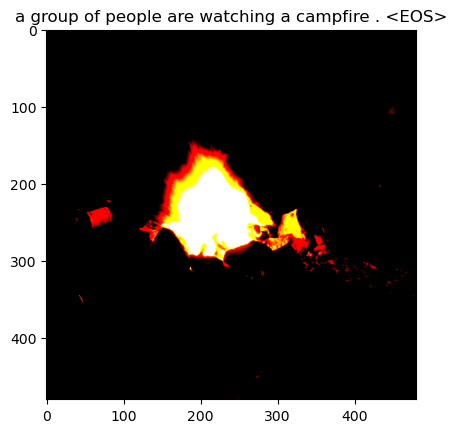

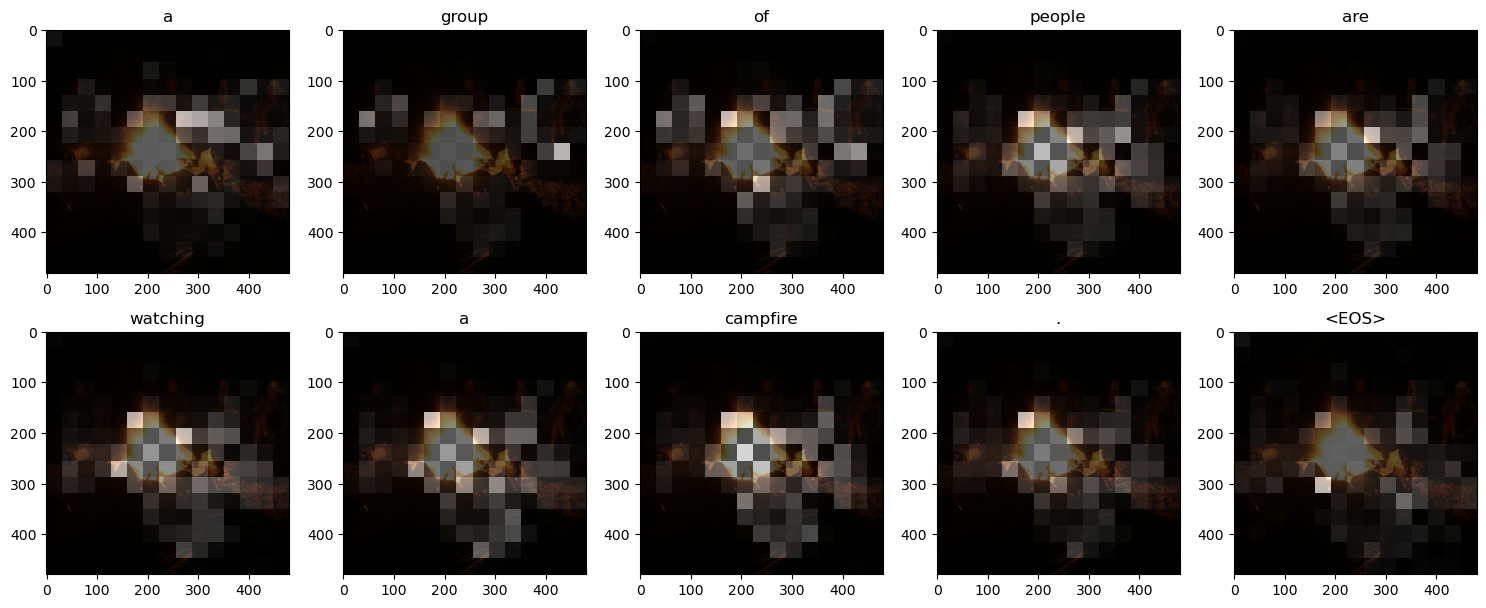

In [36]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


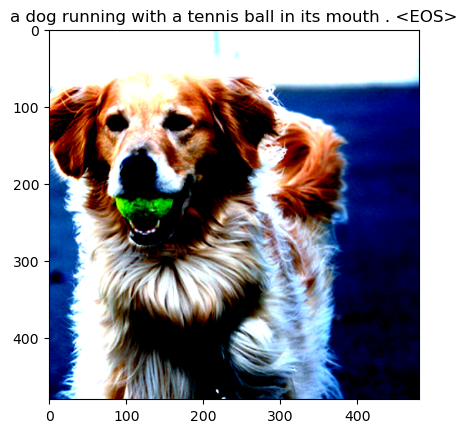

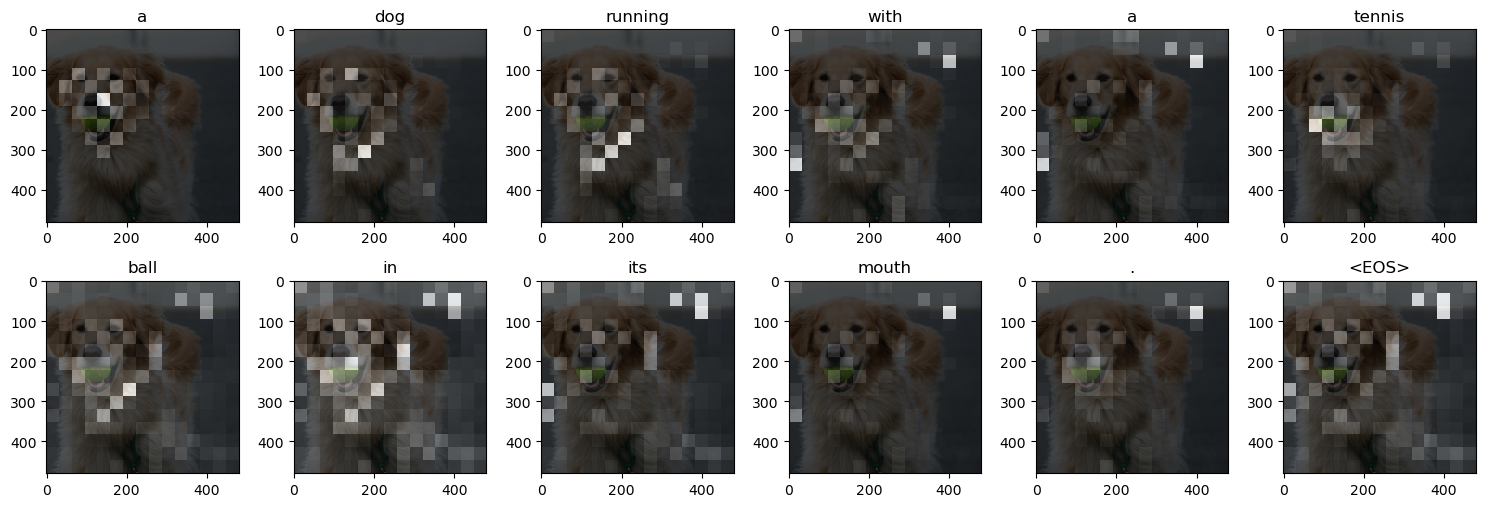

In [37]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)